In [1]:
import dmsh

import torch 

import matplotlib.pyplot as plt

import numpy as np

from core.unstructured_data import DataModule

from scipy.interpolate import interpn

from pathlib import Path

In [2]:
data_path = Path("C:\\Users\\Kevin\\Google Drive\\Research\\QCbranch\\QuadConv\\data\\ignition_center_cut")

grid_file = list(data_path.glob('*.npy'))[0]

grid_data = np.float32(np.load(grid_file))

print(grid_data.shape)

our_data = grid_data[:,:,:,:]

x = np.linspace(0,1,50)
y = np.linspace(0,1,50)

grid = np.meshgrid(x,y)


(450, 50, 50, 4)


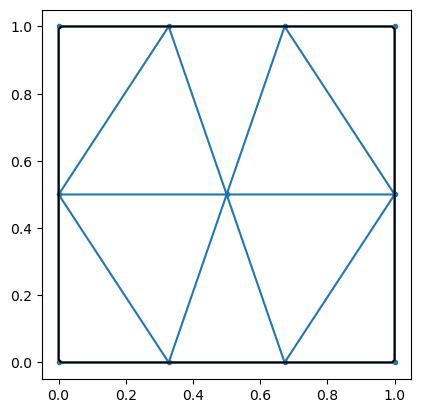

(11, 2)


In [4]:

geo = dmsh.Rectangle(0.0, +1.0, 0.0, +1.0)
X, cells = dmsh.generate(geo, 0.5)
dmsh.helpers.show(X, cells, geo)

print(X.shape)

In [5]:

p1 = dmsh.Path([[0.0, 0.42], [1.0, 0.42]]) 

p0 = dmsh.Path([[0.0, 0.65], [1.0, 0.65]])

shape0  = dmsh.Rectangle(0.0, 0.35, 0.35, 0.75) + dmsh.Rectangle(0.35, 0.65, 0.2, 0.8) + dmsh.Rectangle(0.65, 1.0, 0.00, 1.0)


def target_edge_length_path(x):

    d = np.minimum(p1.dist(x),p0.dist(x))

    return 0.05 * d + 0.01

def target_edge_length(x):

    d = shape0.dist(x)

    d = np.maximum(d,0.0)

    return 0.3 * d + 0.02

rX, rcells = dmsh.generate(geo, target_edge_length, tol=1.0e-3)

import optimesh

rX, rcells = optimesh.optimize_points_cells(rX, rcells, "CVT (full)", 1.0e-3, 100)



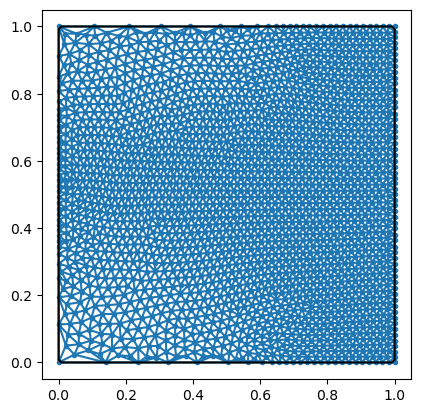

(2189, 2)
[[2055 2146 2123]
 [   3 2145 1874]
 [1946 1827 1583]
 ...
 [ 630  632  631]
 [ 582  581  580]
 [ 581  582  583]]


In [6]:
dmsh.helpers.show(rX, rcells, geo)

print(rX.shape)

print(rcells)

In [7]:
points = (x,y)

mesh = rX

# time by space by channels
mesh_data = np.zeros((our_data.shape[0],mesh.shape[0], our_data.shape[-1]))


for t in range(our_data.shape[0]):

    for c in range(our_data.shape[-1]):

        mesh_data[t,:,c] = interpn(points,our_data[t,:,:,c].T, mesh, method = 'splinef2d')


#mesh_data = np.expand_dims(mesh_data,-1)


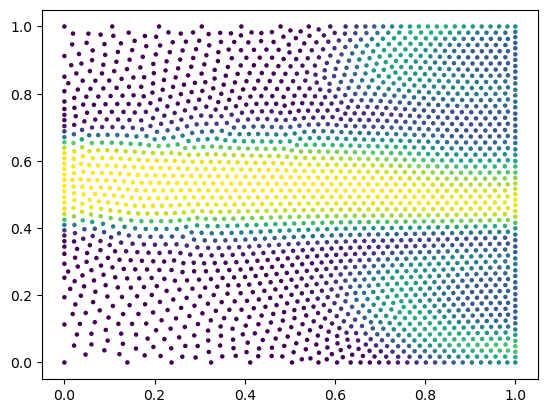

In [8]:
plt.scatter(mesh[:,0], mesh[:,1], s=5, c=mesh_data[50,:,1])
plt.show()

In [20]:
from scipy.interpolate import CloughTocher2DInterpolator

error = np.zeros((mesh_data.shape[0], mesh_data.shape[-1]))

rel_error = np.zeros((mesh_data.shape[0], mesh_data.shape[-1]))

for t in range(our_data.shape[0]):
    for c in (range(our_data.shape[-1])):

        interp = CloughTocher2DInterpolator(mesh, mesh_data[t,:,c])

        pull_back_grid = interp(*grid)

        rel_error[t,c] = np.linalg.norm(pull_back_grid - our_data[t,:,:,c], ord='fro') / np.linalg.norm(1e-5 + our_data[t,:,:,c], ord='fro')

        error[t,c] = np.linalg.norm(pull_back_grid - our_data[t,:,:,c])


print(rel_error.shape)
print(np.mean(rel_error[:,1]))
print(np.mean(error[:,1]))

(450, 4)
0.0012283597340019346
0.02790033089309275


In [227]:
save_path = Path("C:\\Users\\Kevin\\Google Drive\\Research\\QCbranch\\QuadConv\\data") / 'ignition_center_refined_small_mesh'

save_path.mkdir(exist_ok=True)

np.save(save_path / 'points.npy', mesh)

np.save(save_path / 'features.npy', mesh_data)

In [157]:
my_data_module = DataModule(data_dir=save_path,
                        spatial_dim = 2,
                        num_points = 1740,
                        batch_size = 8,
                        channels = (),)

In [158]:
my_data_module.setup(stage='fit')

myDL = my_data_module.train_dataloader()

AttributeError: 'NoneType' object has no attribute 'num_devices'